In [ ]:
from sklearn.model_selection import KFold, train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
import lazyqsar as lq
import seaborn as sns
import os
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
current_directory = os.path.dirname(__file__)
filename = os.path.join(current_directory, "..", "Data", "My_data", "Final_processed.csv")
df = pd.read_csv(filename)
df

,SMILES,Active
0,COc1c(N2C[C@@H]3CCCN[C@@H]3C2)c(F)cc2c(=O)c(C(...,1
1,C=CC1=C(C(=O)O)N2C(=O)[C@H]([C@H]2SC1)NC(=O)/C...,1
2,CC(=O)NC1=CC=C(C=C1)C2=CSC(=N2)C3=CN=CC=C3,0
3,CC(=O)NCC(=O)N[C@@H](CC1=CC=CC=C1)C(=O)NC2(CCC...,0
4,CC(=O)NCC(=O)N[C@@H](CC1=CC=CC=C1)C(=O)NC2(CCC...,0
...,...,...
260,CC[C@@H]1[C@](C)([C@@H]([C@@H](C)C(=O)[C@H](C)...,1
261,CC[C@@H]1[C@](C)([C@@H]([C@@H](C)N(C)C[C@H](C)...,0
262,C[C@@H]1CC(=O)[C@H](O)O[C@@H]([C@H]([C@@H]([C@...,0
263,C1CC1N2C=C(C(=O)C3=C2C=C(C(=C3)F)N4CCNCC4)C(=O)O,0


In [4]:
SMILES = "SMILES"
ACTIVE = "Active"

In [5]:
import matplotlib.pyplot as plt
x = df[ACTIVE]
print(x)

0      1
1      1
2      0
3      0
4      0
      ..
260    1
261    0
262    0
263    0
264    0
Name: Active, Length: 265, dtype: int64


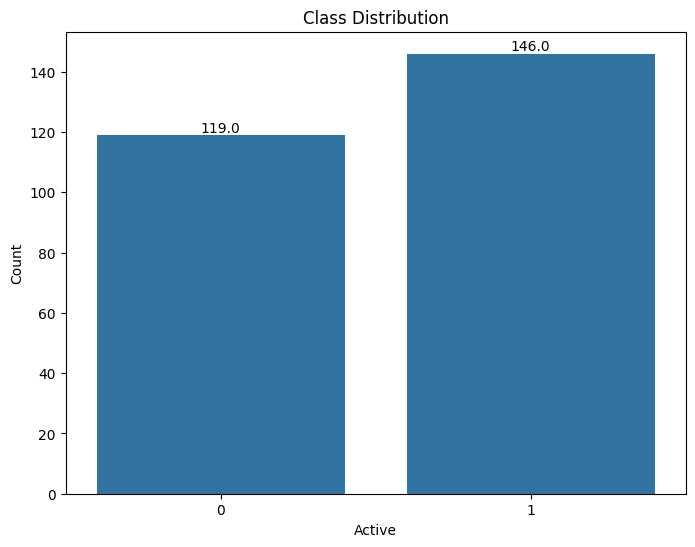

1    146
0    119
Name: Active, dtype: int64


In [6]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x=x, data=df)
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')
plt.xlabel('Active')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

activity_counts = df['Active'].value_counts()
print(activity_counts)

In [7]:
mols = [Chem.MolFromSmiles(x) for x in df['SMILES']]

# Filter out None molecules
valid_mols = [mol for mol in mols if mol is not None]
# Create molecules from SMILES
df['Molecule'] = mols
# Remove rows where the molecule is None
df = df.dropna(subset=['Molecule'])
# Drop the temporary 'Molecule' column
df = df.drop(columns=['Molecule'])

df.to_csv('Data.csv', index=False)

In [8]:
current_directory = os.path.dirname(__file__)
filename = os.path.join(current_directory, "..", "Data", "My_data", "Data.csv")
Data = pd.read_csv(filename)

In [9]:
desc = Data['SMILES']
y = Data['Active']

In [10]:
y = np.array(y)

#  Training with Train-test Split

# **Morgan BinaryClassifier_60**

Streaming output truncated to the last 5000 lines.
[flaml.automl.logger: 01-21 09:21:18] {2218} INFO - iteration 233, current learner rf
[flaml.automl.logger: 01-21 09:21:18] {2391} INFO -  at 13.4s,	estimator rf's best error=0.0545,	best estimator rf's best error=0.0545
[flaml.automl.logger: 01-21 09:21:18] {2218} INFO - iteration 234, current learner rf
[flaml.automl.logger: 01-21 09:21:18] {2391} INFO -  at 13.5s,	estimator rf's best error=0.0545,	best estimator rf's best error=0.0545
[flaml.automl.logger: 01-21 09:21:18] {2218} INFO - iteration 235, current learner rf
[flaml.automl.logger: 01-21 09:21:18] {2391} INFO -  at 13.6s,	estimator rf's best error=0.0545,	best estimator rf's best error=0.0545
[flaml.automl.logger: 01-21 09:21:18] {2218} INFO - iteration 236, current learner rf
[flaml.automl.logger: 01-21 09:21:18] {2391} INFO -  at 13.7s,	estimator rf's best error=0.0545,	best estimator rf's best error=0.0545
[flaml.automl.logger: 01-21 09:21:18] {2218} INFO - iteration 237

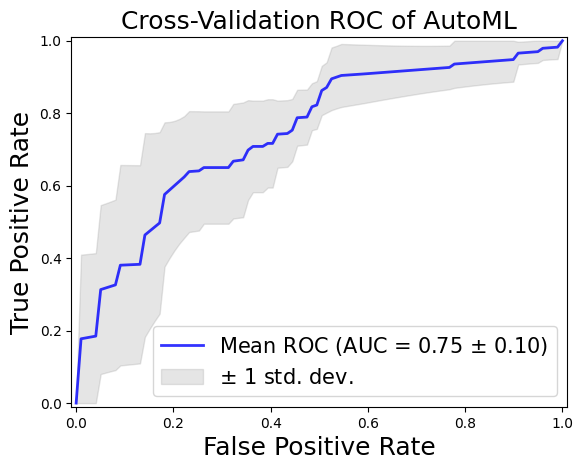

In [14]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc, classification_report
import matplotlib.pyplot as plt
import numpy as np
import lazyqsar as lq
import pandas as pd

# Define SMILES and EXP variables if not defined
SMILES = 'SMILES'
EXP = 'Active'

# Assuming 'desc' and 'y' are your input data
# Initialize AutoML for classification task
model = lq.MorganBinaryClassifier(time_budget_sec=60, estimator_list=["rf", "lgbm", "xgboost"])
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

train_sets = []
test_sets = []
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
all_true_labels = []
all_predictions = []
train_test_splits = []


for i, (train, test) in enumerate(cv.split(desc, y)):
    # Store training and testing sets for the current fold
    train_set = pd.DataFrame(desc.iloc[train])
    test_set = pd.DataFrame(desc.iloc[test])

    # Add the Activity column to both training and testing sets
    train_set['Active'] = y[train]
    test_set['Active'] = y[test]

    # Save the combined training and testing sets for the current fold
    train_file = f"train_{i}.csv"
    test_file = f"test_{i}.csv"
    train_set.to_csv(train_file, index=False)
    test_set.to_csv(test_file, index=False)

    # Fit the model on the training set for the current fold
    model.fit(train_set[SMILES], y[train])

    # Obtain predictions and true labels for the current fold
    y_hat_proba = model.predict_proba(test_set[SMILES])[:, 1]
    fpr, tpr, thresholds = roc_curve(y[test], y_hat_proba)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)

    y_pred = model.predict(test_set[SMILES])
    true_labels = y[test]

    # Append the training and testing sets for the current fold to the lists
    train_sets.append(train_set)
    test_sets.append(test_set)

    # Classification report for the current fold
    print(f"\nClassification Report for Fold {i}:\n")
    print(classification_report(true_labels, y_pred))

    # Accumulate true labels and predictions
    all_true_labels.extend(y[test])
    all_predictions.extend(y_pred)

# Calculate and print the average classification report
print("\nAverage Classification Report Across All Folds:\n")
print(classification_report(all_true_labels, all_predictions))

# Calculate mean ROC curve and AUC
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

# Plot mean ROC curve with boundaries
plt.plot(mean_fpr, mean_tpr, color='b', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Cross-Validation ROC of AutoML', fontsize=18)
plt.legend(loc="lower right", prop={'size': 15})
plt.show()


-------- MorganBinaryClassifier_60 Confusion Matrix --------


Text(50.722222222222214, 0.5, 'Real')

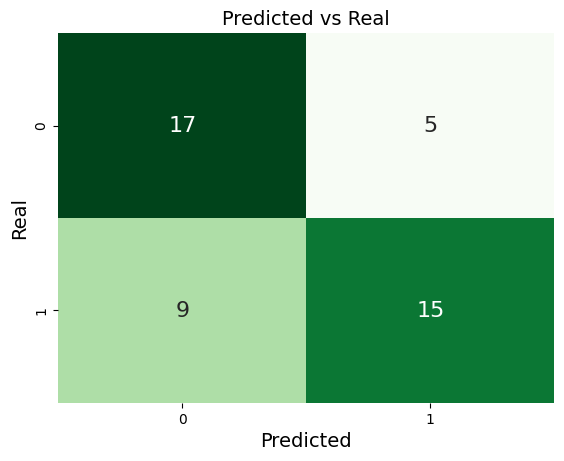

In [12]:
# Confusion Matrix
model_name = 'MorganBinaryClassifier_60'
print(f"-------- {model_name} Confusion Matrix --------")
conf_mat =  confusion_matrix(y[test], y_pred)
ax = sns.heatmap(conf_mat, annot=True, cmap='Greens', cbar=False, annot_kws={"size": 16})
ax.set_title("Predicted vs Real", fontsize=14)
ax.set_xlabel('Predicted', fontsize=14)
ax.set_ylabel('Real', fontsize=14)

# **MorganBinaryClassifier_600**

Streaming output truncated to the last 5000 lines.
[flaml.automl.logger: 01-20 23:34:17] {2391} INFO -  at 131.1s,	estimator lgbm's best error=0.1611,	best estimator xgboost's best error=0.1560
[flaml.automl.logger: 01-20 23:34:17] {2218} INFO - iteration 389, current learner xgboost
[flaml.automl.logger: 01-20 23:34:18] {2391} INFO -  at 131.4s,	estimator xgboost's best error=0.1560,	best estimator xgboost's best error=0.1560
[flaml.automl.logger: 01-20 23:34:18] {2218} INFO - iteration 390, current learner lgbm
[flaml.automl.logger: 01-20 23:34:18] {2391} INFO -  at 131.6s,	estimator lgbm's best error=0.1611,	best estimator xgboost's best error=0.1560
[flaml.automl.logger: 01-20 23:34:18] {2218} INFO - iteration 391, current learner rf
[flaml.automl.logger: 01-20 23:34:18] {2391} INFO -  at 131.9s,	estimator rf's best error=0.1771,	best estimator xgboost's best error=0.1560
[flaml.automl.logger: 01-20 23:34:18] {2218} INFO - iteration 392, current learner lgbm
[flaml.automl.logger: 0

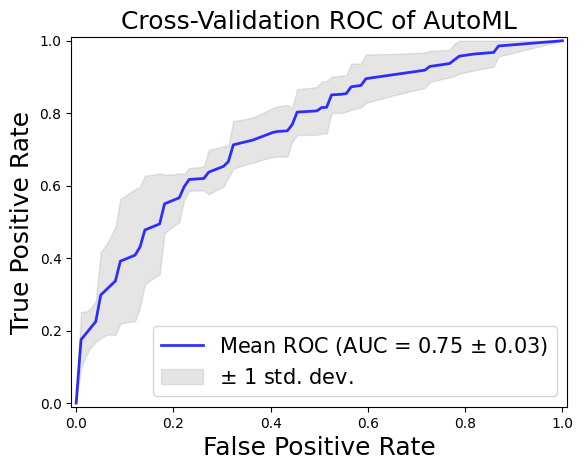

In [24]:
# Define SMILES and EXP variables if not defined
SMILES = 'SMILES'
EXP = 'Active'

# Assuming 'desc' and 'y' are your input data
# Initialize AutoML for classification task
model = lq.MorganBinaryClassifier(time_budget_sec=600, estimator_list=["rf", "lgbm", "xgboost"])
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

train_sets = []
test_sets = []
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
all_true_labels = []
all_predictions = []


#for i, (train, test) in enumerate(cv.split(desc, y)):
for i in range(5):
    train_file = f"train_{i}.csv"
    test_file = f"test_{i}.csv"
    train_set = pd.read_csv(train_file)
    test_set = pd.read_csv(test_file)
    smiles_train = train_set['SMILES']
    y_train = train_set[EXP]

    # Append training and testing sets to the lists
    train_sets.append(train_set)
    test_sets.append(test_set)

    # Fit the model on the training set for the current fold
    model.fit(smiles_train, y_train)

    # Obtain predictions and true labels for the current fold
    y_hat_proba = model.predict_proba(test_set[SMILES])[:, 1]
    fpr, tpr, thresholds = roc_curve(test_set[EXP], y_hat_proba)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)

    y_pred = model.predict(test_set[SMILES])
    true_labels = test_set[EXP]

    # Append the training and testing sets for the current fold to the lists
    train_sets.append(train_set)
    test_sets.append(test_set)

    # Classification report for the current fold
    print(f"\nClassification Report for Fold {i}:\n")
    print(classification_report(true_labels, y_pred))

    # Accumulate true labels and predictions
    all_true_labels.extend(test_set[EXP])
    all_predictions.extend(y_pred)

# Calculate and print the average classification report
print("\nAverage Classification Report Across All Folds:\n")
print(classification_report(all_true_labels, all_predictions))

# Calculate mean ROC curve and AUC
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

# Plot mean ROC curve with boundaries
plt.plot(mean_fpr, mean_tpr, color='b', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Cross-Validation ROC of AutoML', fontsize=18)
plt.legend(loc="lower right", prop={'size': 15})
plt.show()

-------- MorganBinaryClassifier_600 Confusion Matrix --------


Text(50.722222222222214, 0.5, 'Real')

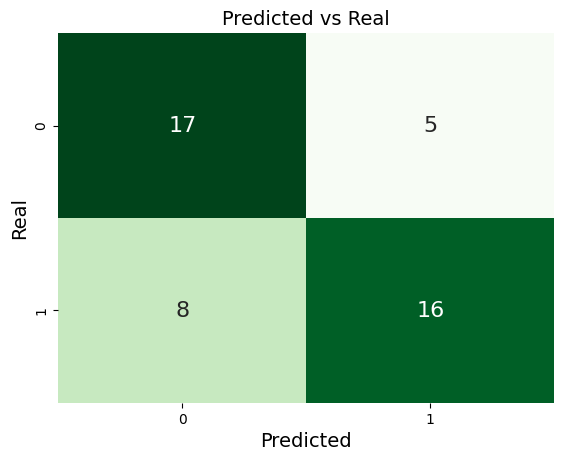

In [25]:
# Confusion Matrix
model_name = 'MorganBinaryClassifier_600'
print(f"-------- {model_name} Confusion Matrix --------")
conf_mat =  confusion_matrix(test_set[EXP], y_pred)
ax = sns.heatmap(conf_mat, annot=True, cmap='Greens', cbar=False, annot_kws={"size": 16})
ax.set_title("Predicted vs Real", fontsize=14)
ax.set_xlabel('Predicted', fontsize=14)
ax.set_ylabel('Real', fontsize=14)

# **ErsiliaBinaryClassifier_60**

[flaml.automl.logger: 01-20 23:52:15] {1679} INFO - task = classification
[flaml.automl.logger: 01-20 23:52:15] {1690} INFO - Evaluation method: holdout
[flaml.automl.logger: 01-20 23:52:15] {1788} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl.logger: 01-20 23:52:15] {1900} INFO - List of ML learners in AutoML Run: ['rf', 'lgbm', 'xgboost']
[flaml.automl.logger: 01-20 23:52:15] {2218} INFO - iteration 0, current learner rf
[flaml.automl.logger: 01-20 23:52:15] {2344} INFO - Estimated sufficient time budget=366s. Estimated necessary time budget=0s.
[flaml.automl.logger: 01-20 23:52:15] {2391} INFO -  at 0.1s,	estimator rf's best error=0.0909,	best estimator rf's best error=0.0909
[flaml.automl.logger: 01-20 23:52:15] {2218} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 01-20 23:52:16] {2391} INFO -  at 0.2s,	estimator lgbm's best error=0.1545,	best estimator rf's best error=0.0909
[flaml.automl.logger: 01-20 23:52:16] {2218} INFO - iteration 2, current learner

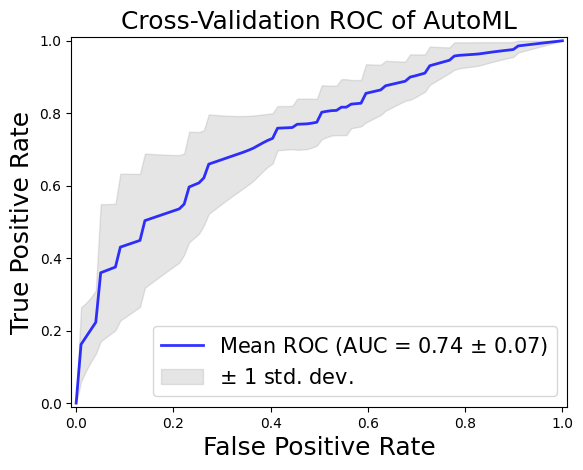

In [26]:
# Define SMILES and EXP variables if not defined
SMILES = 'SMILES'
EXP = 'Active'

# Assuming 'desc' and 'y' are your input data
# Initialize AutoML for classification task
model = lq.ErsiliaBinaryClassifier(time_budget_sec=60, estimator_list=["rf", "lgbm", "xgboost"])
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

train_sets = []
test_sets = []
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
all_true_labels = []
all_predictions = []


#for i, (train, test) in enumerate(cv.split(desc, y)):
for i in range(5):
    train_file = f"train_{i}.csv"
    test_file = f"test_{i}.csv"
    train_set = pd.read_csv(train_file)
    test_set = pd.read_csv(test_file)
    smiles_train = train_set['SMILES']
    y_train = train_set[EXP]

    # Append training and testing sets to the lists
    train_sets.append(train_set)
    test_sets.append(test_set)

    # Fit the model on the training set for the current fold
    model.fit(smiles_train, y_train)

    # Obtain predictions and true labels for the current fold
    y_hat_proba = model.predict_proba(test_set[SMILES])[:, 1]
    fpr, tpr, thresholds = roc_curve(test_set[EXP], y_hat_proba)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)

    y_pred = model.predict(test_set[SMILES])
    true_labels = test_set[EXP]

    # Append the training and testing sets for the current fold to the lists
    train_sets.append(train_set)
    test_sets.append(test_set)

    # Classification report for the current fold
    print(f"\nClassification Report for Fold {i}:\n")
    print(classification_report(true_labels, y_pred))

    # Accumulate true labels and predictions
    all_true_labels.extend(test_set[EXP])
    all_predictions.extend(y_pred)

# Calculate and print the average classification report
print("\nAverage Classification Report Across All Folds:\n")
print(classification_report(all_true_labels, all_predictions))

# Calculate mean ROC curve and AUC
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

# Plot mean ROC curve with boundaries
plt.plot(mean_fpr, mean_tpr, color='b', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Cross-Validation ROC of AutoML', fontsize=18)
plt.legend(loc="lower right", prop={'size': 15})
plt.show()

-------- ErsiliaBinaryClassifier_60 Confusion Matrix --------


Text(50.722222222222214, 0.5, 'Real')

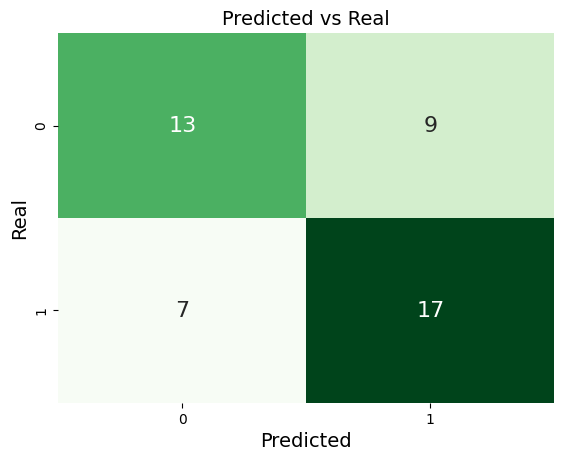

In [27]:
# Confusion Matrix
model_name = 'ErsiliaBinaryClassifier_60'
print(f"-------- {model_name} Confusion Matrix --------")
conf_mat =  confusion_matrix(test_set[EXP], y_pred)
ax = sns.heatmap(conf_mat, annot=True, cmap='Greens', cbar=False, annot_kws={"size": 16})
ax.set_title("Predicted vs Real", fontsize=14)
ax.set_xlabel('Predicted', fontsize=14)
ax.set_ylabel('Real', fontsize=14)

# **ErsiliaBinaryClassifier_600**

Streaming output truncated to the last 5000 lines.
[flaml.automl.logger: 01-21 00:17:26] {2218} INFO - iteration 5, current learner rf
[flaml.automl.logger: 01-21 00:17:26] {2391} INFO -  at 2.1s,	estimator rf's best error=0.2820,	best estimator lgbm's best error=0.2536
[flaml.automl.logger: 01-21 00:17:26] {2218} INFO - iteration 6, current learner rf
[flaml.automl.logger: 01-21 00:17:26] {2391} INFO -  at 2.2s,	estimator rf's best error=0.2820,	best estimator lgbm's best error=0.2536
[flaml.automl.logger: 01-21 00:17:26] {2218} INFO - iteration 7, current learner rf
[flaml.automl.logger: 01-21 00:17:26] {2391} INFO -  at 2.4s,	estimator rf's best error=0.2820,	best estimator lgbm's best error=0.2536
[flaml.automl.logger: 01-21 00:17:26] {2218} INFO - iteration 8, current learner rf
[flaml.automl.logger: 01-21 00:17:27] {2391} INFO -  at 2.6s,	estimator rf's best error=0.2764,	best estimator lgbm's best error=0.2536
[flaml.automl.logger: 01-21 00:17:27] {2218} INFO - iteration 9, curr

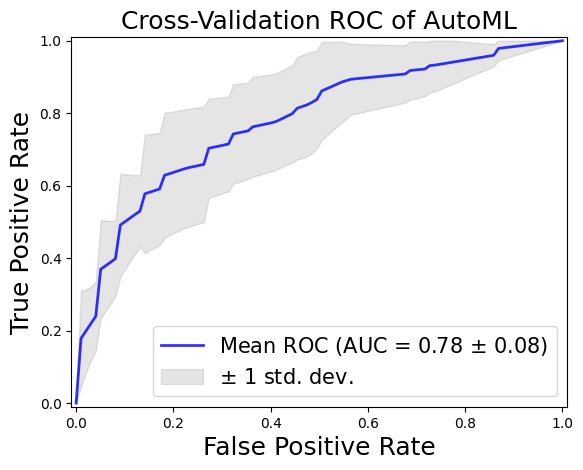

In [28]:
# Define SMILES and EXP variables if not defined
SMILES = 'SMILES'
EXP = 'Active'

# Assuming 'desc' and 'y' are your input data
# Initialize AutoML for classification task
model = lq.ErsiliaBinaryClassifier(time_budget_sec=600, estimator_list=["rf", "lgbm", "xgboost"])
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

train_sets = []
test_sets = []
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
all_true_labels = []
all_predictions = []


#for i, (train, test) in enumerate(cv.split(desc, y)):
for i in range(5):
    train_file = f"train_{i}.csv"
    test_file = f"test_{i}.csv"
    train_set = pd.read_csv(train_file)
    test_set = pd.read_csv(test_file)
    smiles_train = train_set['SMILES']
    y_train = train_set[EXP]

    # Append training and testing sets to the lists
    train_sets.append(train_set)
    test_sets.append(test_set)

    # Fit the model on the training set for the current fold
    model.fit(smiles_train, y_train)

    # Obtain predictions and true labels for the current fold
    y_hat_proba = model.predict_proba(test_set[SMILES])[:, 1]
    fpr, tpr, thresholds = roc_curve(test_set[EXP], y_hat_proba)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)

    y_pred = model.predict(test_set[SMILES])
    true_labels = test_set[EXP]

    # Append the training and testing sets for the current fold to the lists
    train_sets.append(train_set)
    test_sets.append(test_set)

    # Classification report for the current fold
    print(f"\nClassification Report for Fold {i}:\n")
    print(classification_report(true_labels, y_pred))

    # Accumulate true labels and predictions
    all_true_labels.extend(test_set[EXP])
    all_predictions.extend(y_pred)

# Calculate and print the average classification report
print("\nAverage Classification Report Across All Folds:\n")
print(classification_report(all_true_labels, all_predictions))

# Calculate mean ROC curve and AUC
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

# Plot mean ROC curve with boundaries
plt.plot(mean_fpr, mean_tpr, color='b', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Cross-Validation ROC of AutoML', fontsize=18)
plt.legend(loc="lower right", prop={'size': 15})
plt.show()

-------- ErsiliaBinaryClassifier_600 Confusion Matrix --------


Text(50.722222222222214, 0.5, 'Real')

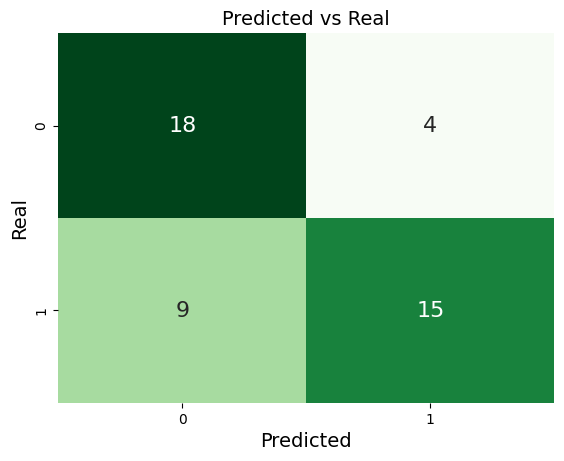

In [29]:
# Confusion Matrix
model_name = 'ErsiliaBinaryClassifier_600'
print(f"-------- {model_name} Confusion Matrix --------")
conf_mat =  confusion_matrix(test_set[EXP], y_pred)
ax = sns.heatmap(conf_mat, annot=True, cmap='Greens', cbar=False, annot_kws={"size": 16})
ax.set_title("Predicted vs Real", fontsize=14)
ax.set_xlabel('Predicted', fontsize=14)
ax.set_ylabel('Real', fontsize=14)

The model using ErsiliaBinaryClassifier and train time of 600 performed well than the other models. This is because as seen in the AUC-ROC curve. It has the highest mean AUC value (0.78) and the smallest standard deviation (0.08) for the 5-fold cross-validation. This indicates that the model has consistently performed well across all five folds of the cross-validation, suggesting better generalization ability compared to the other models.

The other three models have lower mean AUC values (0.75, 0.74, and 0.75) and larger standard deviations (0.10, 0.07, and 0.03), which indicates more variability in performance across the folds. This could be due to overfitting or other issues with the model.

In general, a lower standard deviation for the AUC ROC curve indicates greater consistency in model performance across different data splits. Therefore, the Mean ROC (AUC=0.78 +- 0.08) is the best model based on these metrics.

We would now proceed to training our entire data with this model

# **Training on the Entire data**

In [10]:
# Assuming Data is your original dataframe
# Define SMILES and EXP variables if not defined
SMILES = 'SMILES'
EXP = 'Active'

no_of_fold = 5
results = []

for i in range(no_of_fold):
    # Use the entire dataset for training
    train = Data

    # Separate features (SMILES) and target variable (EXP) for training
    smiles_train = train[SMILES]
    y_train = train[EXP]

    # Initialize and fit the model: Our best model was
    model = lq.ErsiliaBinaryClassifier(time_budget_sec=600, estimator_list=["rf", "lgbm", "xgboost"])
    model.fit(smiles_train, y_train)

    # Separate features (SMILES) for testing (you can use the entire dataset or a different dataset for testing)
    smiles_test = Data[SMILES]

    # Predict probabilities using the trained model
    y_hat = model.predict_proba(smiles_test)

    # Store the results
    results.append(y_hat)

# Calculate the mean score
mean_score = np.mean(results, axis=0)
mean_score


Streaming output truncated to the last 5000 lines.
[flaml.automl.logger: 01-21 08:32:00] {2391} INFO -  at 339.0s,	estimator rf's best error=0.1520,	best estimator rf's best error=0.1520
[flaml.automl.logger: 01-21 08:32:00] {2218} INFO - iteration 415, current learner lgbm
[flaml.automl.logger: 01-21 08:32:00] {2391} INFO -  at 339.5s,	estimator lgbm's best error=0.1629,	best estimator rf's best error=0.1520
[flaml.automl.logger: 01-21 08:32:00] {2218} INFO - iteration 416, current learner rf
[flaml.automl.logger: 01-21 08:32:01] {2391} INFO -  at 340.1s,	estimator rf's best error=0.1520,	best estimator rf's best error=0.1520
[flaml.automl.logger: 01-21 08:32:01] {2218} INFO - iteration 417, current learner lgbm
[flaml.automl.logger: 01-21 08:32:01] {2391} INFO -  at 340.6s,	estimator lgbm's best error=0.1629,	best estimator rf's best error=0.1520
[flaml.automl.logger: 01-21 08:32:01] {2218} INFO - iteration 418, current learner rf
[flaml.automl.logger: 01-21 08:32:02] {2391} INFO -  

array([[0.26375168, 0.73624832],
       [0.08752958, 0.91247042],
       [0.67340399, 0.32659601],
       [0.50653471, 0.49346529],
       [0.49788052, 0.50211948],
       [0.66747336, 0.33252664],
       [0.07510563, 0.92489437],
       [0.13891682, 0.86108318],
       [0.12851645, 0.87148355],
       [0.08413889, 0.91586111],
       [0.11462944, 0.88537056],
       [0.19568307, 0.80431693],
       [0.19608356, 0.80391644],
       [0.68146948, 0.31853052],
       [0.65754289, 0.34245711],
       [0.7972289 , 0.2027711 ],
       [0.90569541, 0.09430459],
       [0.83009864, 0.16990136],
       [0.88326497, 0.11673503],
       [0.40337032, 0.59662968],
       [0.70733074, 0.29266926],
       [0.28960208, 0.71039792],
       [0.21939274, 0.78060726],
       [0.2239382 , 0.7760618 ],
       [0.55013819, 0.44986181],
       [0.31419499, 0.68580501],
       [0.44946097, 0.55053903],
       [0.75503425, 0.24496575],
       [0.66674219, 0.33325781],
       [0.4449061 , 0.5550939 ],
       [0.

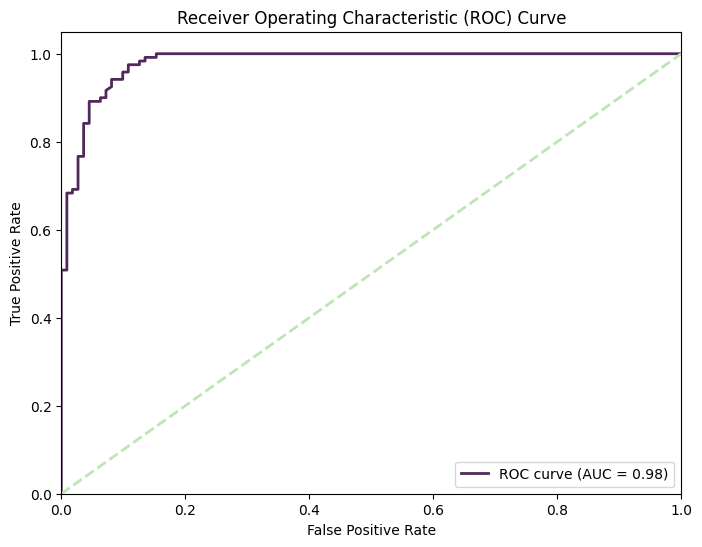

In [11]:
# We need the real results, the activity of the test set
y_test = Data['Active']

# We use the sklearn package to calculate the roc_curve and plot it
y_hat = y_hat[:,1]
fpr, tpr, _ = roc_curve(y_test, y_hat)
auroc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='#50285a', lw=2, label=f'ROC curve (AUC = {auroc:.2f})')
plt.plot([0, 1], [0, 1], color='#bee6b4', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

[Text(0, 0.5, 'Inactive'), Text(0, 1.5, 'Active')]

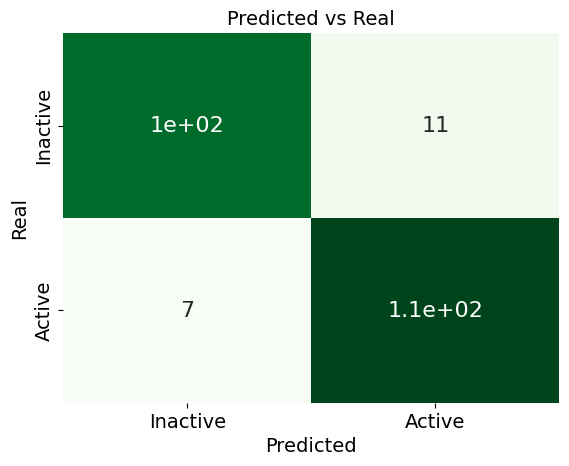

In [12]:
proba_cutoff = 0.5
y_hat_bin = [1 if x >= proba_cutoff else 0 for x in y_hat]


cf_matrix = confusion_matrix(y_test, y_hat_bin)

ax = sns.heatmap(cf_matrix, annot=True, cmap='Greens', cbar=False, annot_kws={"size": 16})
ax.set_title("Predicted vs Real", fontsize=14)
ax.set_xlabel('Predicted', fontsize=14)
ax.set_ylabel('Real', fontsize=14)

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Inactive','Active'], fontsize=14)
ax.yaxis.set_ticklabels(['Inactive','Active'], fontsize=14)

In [13]:
model.save("model_eosce_full600.joblib")